In [25]:
from TradingviewData import TradingViewData,Interval

request = TradingViewData()

In [26]:
request.search('SOLUSD', 'BINANCE')

ERROR:TradingviewData.main:Expecting value: line 1 column 1 (char 0)


[]

<Axes: >

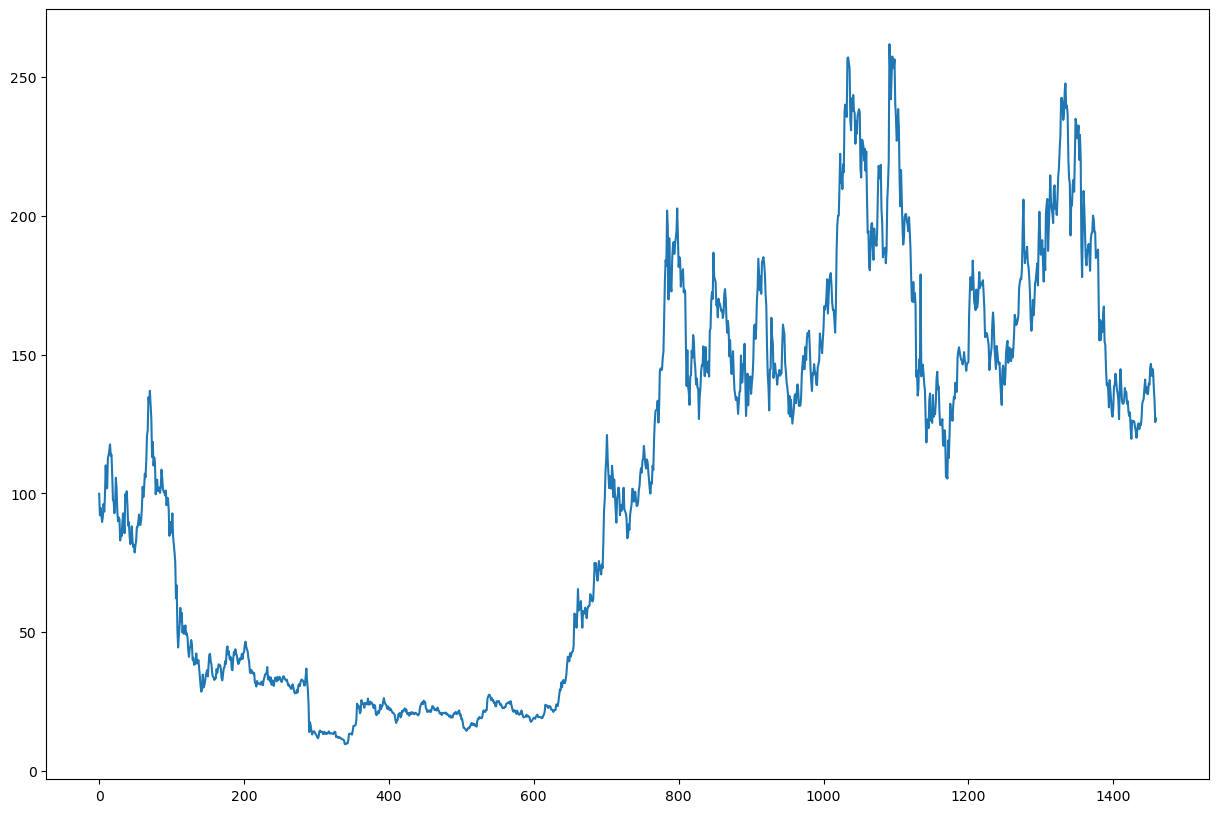

In [31]:
solana_data = request.get_hist(
    symbol='SOLUSD', 
    exchange='BINANCE', 
    interval=Interval.daily, 
    n_bars= 4 * 365
)

solana_data.close.plot(figsize=(15,10),use_index=False)

<Axes: >

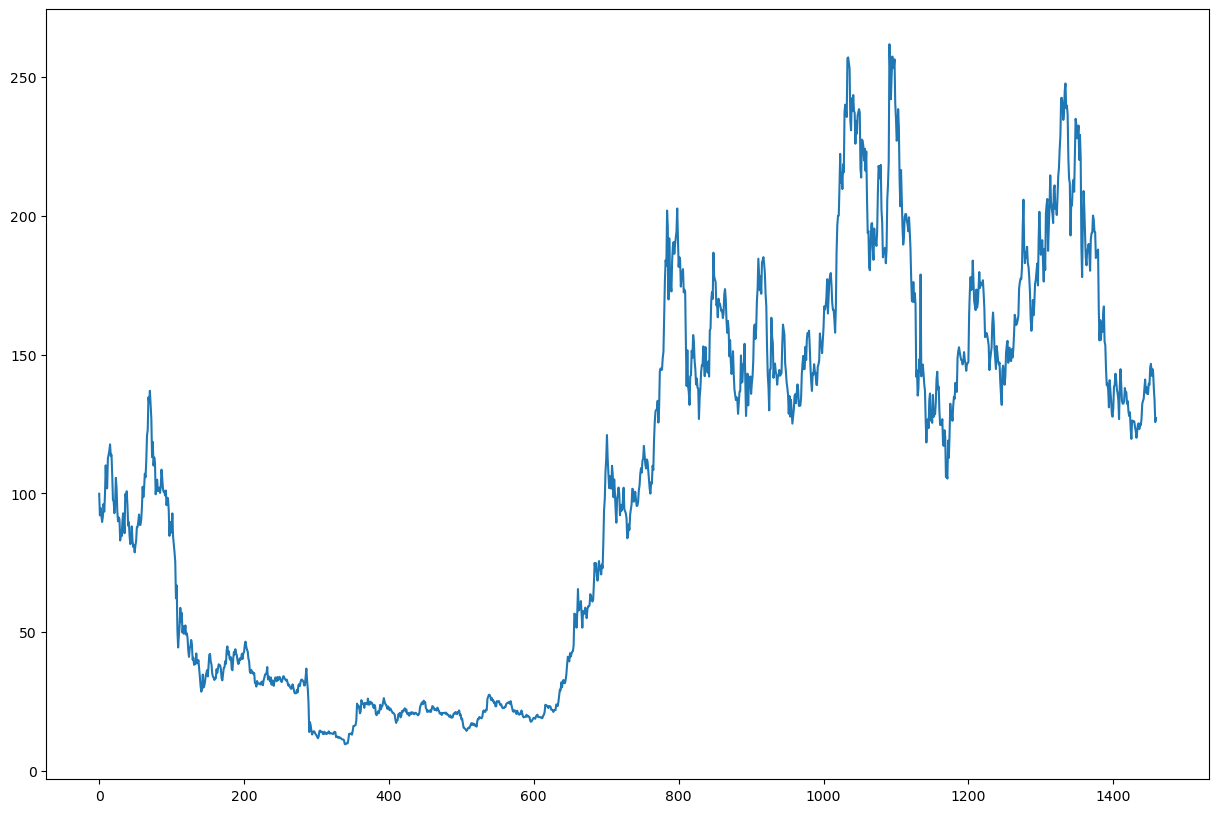